In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import os

if os.getcwd().split("\\")[-1] == "homework":
    os.chdir("../")

# Homework 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

### Notation
(Hidden LaTeX commands)

$$\newcommand{\mux}{\tilde{\boldsymbol{\mu}}}$$
$$\newcommand{\wtan}{\boldsymbol{\text{w}}^{\text{tan}}}$$
$$\newcommand{\wtarg}{\boldsymbol{\text{w}}^{\text{port}}}$$
$$\newcommand{\mutarg}{\tilde{\boldsymbol{\mu}}^{\text{port}}}$$
$$\newcommand{\wEW}{\boldsymbol{\text{w}}^{\text{EW}}}$$
$$\newcommand{\wRP}{\boldsymbol{\text{w}}^{\text{RP}}}$$
$$\newcommand{\wREG}{\boldsymbol{\text{w}}^{\text{REG}}}$$

***

# 1. HMC's Approach

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

### 1. 
There are thousands of individual risky assets in which HMC can invest.  Explain why MV optimization across 1,000 securities is infeasible.

The problem is estimating the covariance matrix. This matrix would have roughly 500,000 covariances to predict. Some of these securities may have very little data, and their covariance estimates would have large standard errors. This is why similar securities are grouped into asset classes and optimization (and estimating the covariance) is done at the asset class level.


### 2.
Rather than optimize across all securities directly, HMC runs a two-stage optimization.
1. They build asset class portfolios with each one optimized over the securities of the specific asset class.  
2. HMC combines the asset-class portfolios into one total optimized portfolio.

In order for the two-stage optimization to be a good approximation of the full MV-optimization on all assets, what must be true of the partition of securities into asset classes?

You want to maximize correlation within asset classes and minimize correlation between asset classes. In other words, you want to put similar moving securities into the same asset class. You can think about this 'asset class' as one security whos PnL is the sum of the PnL of it's constituents. You do this for all asset classes and then optimize across these 'asset class' securities.


### 3.
Should TIPS form a new asset class or be grouped into one of the other 11 classes?

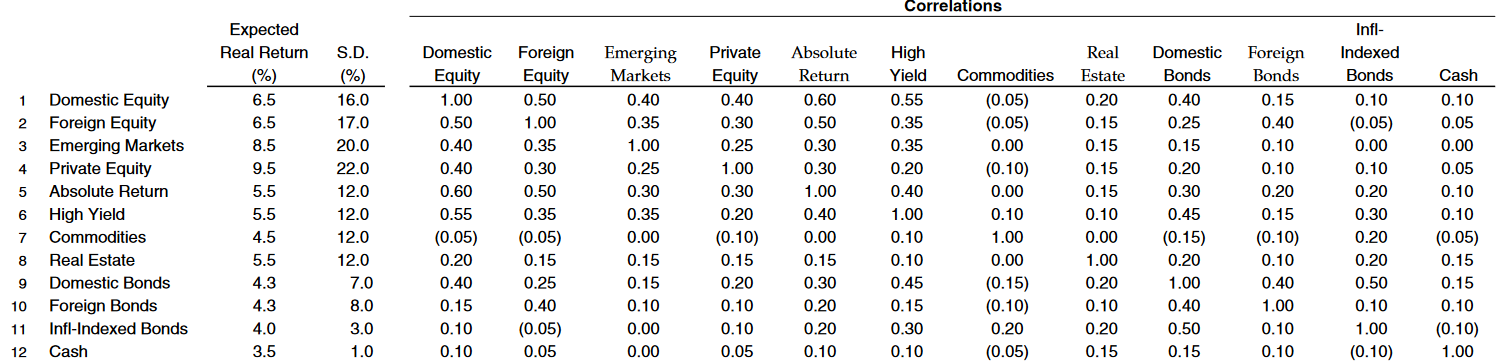

From the correlation matrix we can see the correlation of Inflation indedex bonds is lower with other assets. The highest is .50 with Domestic Bonds
which is not high enough to group together.


### 4. 
Why does HMC focus on real returns when analyzing its portfolio allocation? Is this just a matter of scaling, or does using real returns versus nominal returns potentially change the MV solution?

The whole point of TIPS is to protect against inflation. By using real returns we are able to see how well TIPS are doing in protecting against inflation. But if other assets also protect against inflation, then why would you want to hold TIPS? This is why we use real returns for all asset classes, so we can compare the returns of TIPS to other assets, and account for inflation in both cases. Using nominal returns would not compare apples to apples and would likely change the MV solution.


### 5.
The case discusses the fact that Harvard places bounds on the portfolio allocation rather than implementing whatever numbers come out of the MV optimization problem.

How might we adjust the stated optimization problem in the lecture notes to reflect the extra constraints Harvard is using in their bounded solutions given in Exhibits 5 and 6?

One way to do this is to add a constraint to the optimization problem for each asset class.


### 6. 
Exhibits 5 shows zero allocation to domestic equities and domestic bonds across the entire computed range of targeted returns, (5.75% to 7.25%). Conceptually, why is the constraint binding in all these cases? What would the unconstrained portfolio want to do with those allocations and why?

The unconstrained portfolio would likely want to short these asset classes. It believes that domestic equities and domestic bonds are not giving good (inflation adjusted) returns for their risk.

### 7.
Exhibit 6 changes the constraints, (tightening them in most cases.) How much deterioration do we see in the mean-variance tradeoff that Harvard achieved?

The mean is an input to the optimization, so this will remain the same no matter the contraints. The variances is larger in Exbibit 6 but not by much.

***

# 2 Mean-Variance Optimization

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code. </i>

### Data
You will need the file in the github repo, `data/multi_asset_etf_data.xlsx`.
- The time-series data gives monthly returns for the 11 asset classes and a short-term Treasury-bill fund return, ("SHV",) which we consider as the risk-free rate.
- The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)
- These are nominal returns-they are not adjusted for inflation, and in our calculations we are not making any adjustment for inflation.
- The exhibit data that comes via Harvard with the case is unnecessary for our analysis.


In [113]:
file_path = r"data/multi_asset_etf_data.xlsx"
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")

descriptions: (12, 7)
prices: (165, 13)
total returns: (164, 13)
excess returns: (164, 12)


In [114]:
# ticker mapping
ticker_mapping = {tick: name for tick, name in zip(dfs_raw['descriptions']['ticker'], dfs_raw['descriptions']['shortName'])}

# Custom mapping
custom_ticker_mapping = {
    'SPY': 'S&P 500', 
    'EFA': 'L-M cap foreign established markets', 
    'EEM': 'L-M cap emerging markets', 
    'PSP': 'Private Equity', 
    'QAI': 'Hedge Funds', 
    'HYG': 'High Yield Corp.', 
    'DBC': 'Commodities', 
    'IYR': 'U.S. Real Estate', 
    'IEF': '7Y-10Y Treas. Bond', 
    'BWX': 'Foreign IG Bonds', 
    'TIP': 'TIPS', 
    'SHV': 'Short Treas. Bonds'
 }



### Model
We are going to analyze the problem in terms of **excess** returns.
- Thus, you will focus on the `Excess Returns` section of the lecture notes, especially the formulas on slide 50.
- Be sure to use the`excess returns` tab of the data.

In [115]:
df_returns = dfs_raw["excess returns"]
df_returns = df_returns.set_index("Date")
# df_returns = df_returns.rename(columns=custom_ticker_mapping)

print(df_returns.shape)
display(df_returns.head())

(164, 11)


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2011-02-28,0.006527,0.041620,-0.000527,0.035408,0.014264,-0.002174,0.045113,0.040056,0.002493,0.034647,0.007118
2011-03-31,0.008255,0.026409,0.062723,-0.024055,0.000251,-0.001719,-0.011107,0.016495,0.005348,-0.000052,0.011730
2011-04-30,0.048261,0.045015,0.026783,0.055715,0.015432,0.017868,0.046089,0.058127,0.018490,0.028418,0.023236
2011-05-31,-0.013447,-0.051625,-0.029301,-0.021962,0.001432,0.025156,0.010233,-0.041465,0.000099,-0.011115,0.002758
2011-06-30,-0.000270,-0.042817,-0.009528,-0.012280,-0.005878,-0.005217,-0.031233,-0.042754,-0.010948,-0.017042,0.007377



### Format
In the questions below, **annualize the statistics** you report.
- Annualize the mean of monthly returns with a scaling of 12.
- Annualize the volatility of monthly returns with a scaling of $\sqrt{12}$
- The Sharpe Ratio is the mean return divided by the volatility of returns. Accordingly, we can annualize the Sharpe Ratio with a scaling of $\sqrt{12}$
- Note that we are not scaling the raw timeseries data, just the statistics computed from it (mean, vol, Sharpe). 

### Footnotes

#### Data File
* The case does not give time-series data, so this data has been compiled outside of the case, and it intends to represent the main asset classes under consideration via various ETFs. For details on the specific securities/indexes, check the “Info” tab of the data.

#### Risk-free rate
* In the lecture-note we considered a constant risk-free rate. It is okay that our risk-free rate changes over time, but the assumption is that investors know it’s value one-period ahead of time. Thus, at any given point in time, it is a risk-free rate for the next period. (This is often discussed as the "bank account" or "money market account" in other settings.

## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mux_i}{\sigma_i}$$


In [116]:
def calc_summary(df, scale=1):
    return df.apply(lambda x: pd.Series({
        "mean": x.mean() * scale,
        "std": x.std() * np.sqrt(scale),
        "sharpe": x.mean() / x.std() * np.sqrt(scale)  
    }))

df_summary = calc_summary(df_returns, 12)
df_summary = df_summary.rename(columns=custom_ticker_mapping)

display(df_summary)

,Foreign IG Bonds,Commodities,L-M cap emerging markets,L-M cap foreign established markets,High Yield Corp.,7Y-10Y Treas. Bond,U.S. Real Estate,Private Equity,Hedge Funds,S&P 500,TIPS
mean,-0.011888,-0.009086,0.026960,0.055037,0.037356,0.013939,0.077912,0.092851,0.014959,0.126983,0.016844
std,0.081671,0.168455,0.179940,0.152203,0.077289,0.063197,0.169585,0.215238,0.049007,0.143066,0.051258
sharpe,-0.145563,-0.053935,0.149829,0.361605,0.483335,0.220561,0.459426,0.431386,0.305241,0.887578,0.328618



## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?


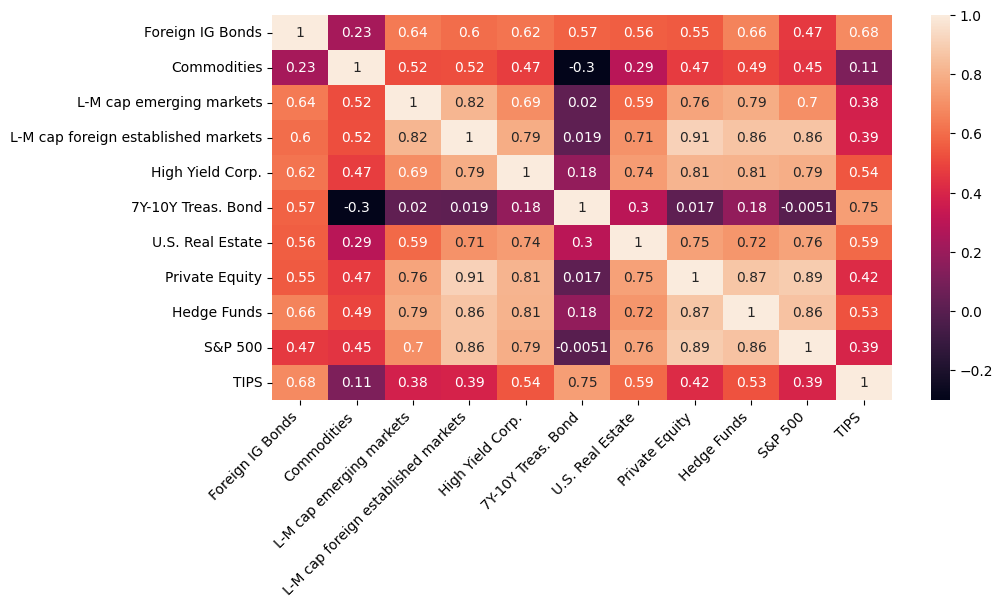

In [117]:
df_corr = (df_returns
           .rename(columns=custom_ticker_mapping)
           .corr())

# Plot with seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(df_corr, annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.show()

- Highest correlation pair: (Private Equity, Established Foreign Markets) with 0.91
- Lowest correlation pair: (7Y-10Y Treasury Bonds, Commodities) with -.3

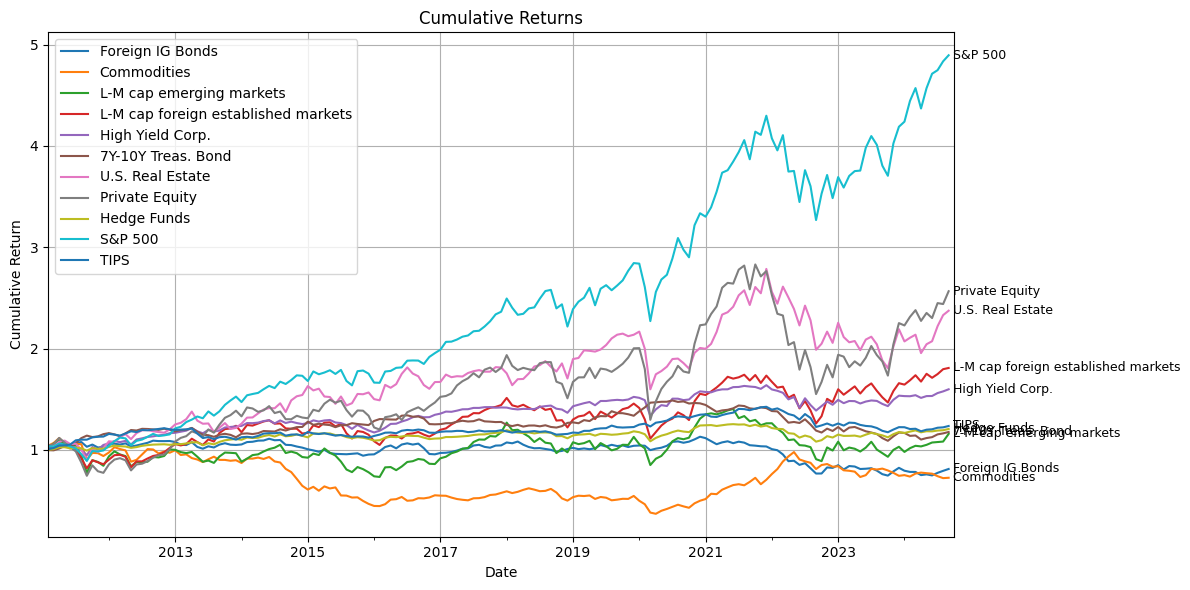

In [118]:
def plot_cumulative_returns(df_returns):
    # Calculate cumulative returns
    df_cum = (df_returns + 1).cumprod()

    # Plot cumulative returns
    ax = df_cum.plot(ax=plt.gca())
    # Annotate each line with its label at the end
    for line, name in zip(ax.get_lines(), df_cum.columns):
        y = line.get_ydata()[-1]  # Get the last y value of the line
        ax.text(df_cum.index[-1], y, f' {name}', va='center', fontsize=9)

    # Optional: adjust plot limits to ensure labels fit in the figure
    plt.xlim(df_cum.index.min(), df_cum.index.max() + pd.Timedelta(days=30))

    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(12, 6))
plot_cumulative_returns(df_returns.rename(columns=custom_ticker_mapping))

TIPs did roughly the same as domestic bonds, but outperformed foreign bonds. ITs important to note that domestic bonds were slightly out
performing TIPS from 2011-2022.


## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $\wtan$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to $\wtan$.

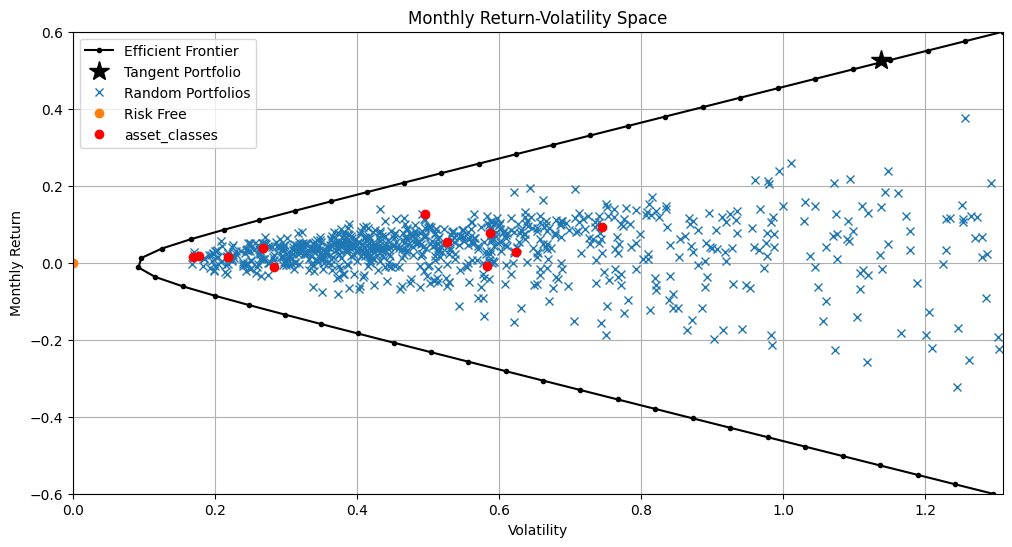

Tangency Portfolio Weights: ['-2.73', '0.11', '0.62', '-0.53', '0.83', '4.68', '-0.88', '-0.28', '-7.22', '4.90', '-0.51']
Tangency Portfolio Sum of Weights: -1.00
Tangency Portfolio Mean Return: 0.53
Tangency Portfolio Volatility: 1.14
Tangency Portfolio Sharpe Ratio: 0.46


In [119]:
def compute_stats(weights, mu_hat, sigma_hat):
    p_return = weights.T @ mu_hat
    p_vol = np.sqrt(weights.T @ sigma_hat @ weights)
    return p_vol, p_return

def run_optimization(target_return, mu_hat, sigma_hat, bounds=None):
    n = len(mu_hat)
    x0 = np.ones(n) / n
    
    def objective(x): 
        return x.T @ sigma_hat @ x
    constraints = [
        # Sum of weights
        {'type': 'eq', 
         'fun': lambda weights: np.sum(weights) - 1
         },  
        # target return
        {'type': 'eq', 
         'fun': lambda weights: np.dot(weights, mu_hat) - target_return
         }
    ]
    
    result = scipy.optimize.minimize(objective, x0, constraints=constraints, bounds=bounds)
    
    return [np.sqrt(result.fun), target_return, result.x]

  
def tangent_portfolio(mu_hat, sigma_hat):
    sigma_inv = np.linalg.inv(sigma_hat)
    weights = sigma_inv @ mu_hat
    weights = weights / np.sum(weights)
    
    t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat)
    if t_return < 0:
        weights *= -1
        t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat)
    return [t_vol, t_return, weights]

def plot_return_vol_space(df_returns, only_frontier=False, sub_label = "", color='black', risk_free_rate=0):
    mu_hat = df_returns.mean().values
    sigma_hat = df_returns.cov().values
    
    # Efficient frontier
    eff_set = [run_optimization(x, mu_hat, sigma_hat) 
               for x in np.linspace(-.6, .6)]
    
    if not only_frontier:
        # random portfolios
        n_random = 1000
        random_weights = np.random.randn(n_random, len(mu_hat))
        random_weights /= random_weights.sum(axis=1)[:, None]
        random_set = [compute_stats(w, mu_hat, sigma_hat)
                      for w in random_weights]
        
        # risk free
        risk_free = [0, risk_free_rate]
    
    # tangent portfolio
    t_vol, t_return, t_weights = tangent_portfolio(mu_hat, sigma_hat)
    # # Use grid search over mu
    # sharpe_ratios = [p[1] / p[0] for p in eff_set]
    # max_sharpe_idx = np.argmax(sharpe_ratios)
    # t_vol, t_return, t_weights = eff_set[max_sharpe_idx]
    
    # plot
    plt.plot([p[0] for p in eff_set], [p[1] for p in eff_set], '.-', label=sub_label + 'Efficient Frontier', color=color)
    plt.plot(t_vol, t_return, '*', markersize=15, label=sub_label + 'Tangent Portfolio', color=color)
    # plt.plot(m_vol, m_return, '*', markersize=15, label=sub_label + 'Mark Tangent Portfolio', color="red")
    if not only_frontier:
        plt.plot([p[0] for p in random_set], [p[1] for p in random_set], 'x', label=sub_label + 'Random Portfolios')
        plt.plot(*risk_free, 'o', label='Risk Free')
        
        # Assets
        for i, txt in enumerate(df_returns.columns):
            if i ==0:
                plt.plot(np.sqrt(sigma_hat[i, i]), mu_hat[i], 'or', label="asset_classes")
            else:
                plt.plot(np.sqrt(sigma_hat[i, i]), mu_hat[i], 'or')
    plt.xlabel('Volatility')
    plt.ylabel('Monthly Return')
    plt.title('Monthly Return-Volatility Space')
    plt.grid(True)
    
    # Restrict based on efficient froniter
    if not only_frontier:
        plt.xlim(0, max([p[0] for p in eff_set]))
        plt.ylim(min([p[1] for p in eff_set]), max([p[1] for p in eff_set]))
    
    plt.legend()
    return t_vol, t_return, t_weights
    
    
plt.figure(figsize=(12, 6))
tangent_vol, tangent_return, tangent_weights = plot_return_vol_space(df_returns * 12)


plt.show()
print(f"Tangency Portfolio Weights: {[f'{weight:.2f}' for weight in tangent_weights]}")
print(f"Tangency Portfolio Sum of Weights: {sum(tangent_weights):.2f}")
print(f"Tangency Portfolio Mean Return: {tangent_return:.2f}")
print(f"Tangency Portfolio Volatility: {tangent_vol:.2f}")
print(f"Tangency Portfolio Sharpe Ratio: {tangent_return / tangent_vol:.2f}")

* Does the ranking of weights align with the ranking of Sharpe ratios?

todo

Not exactly sure what they mean with this question.


## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

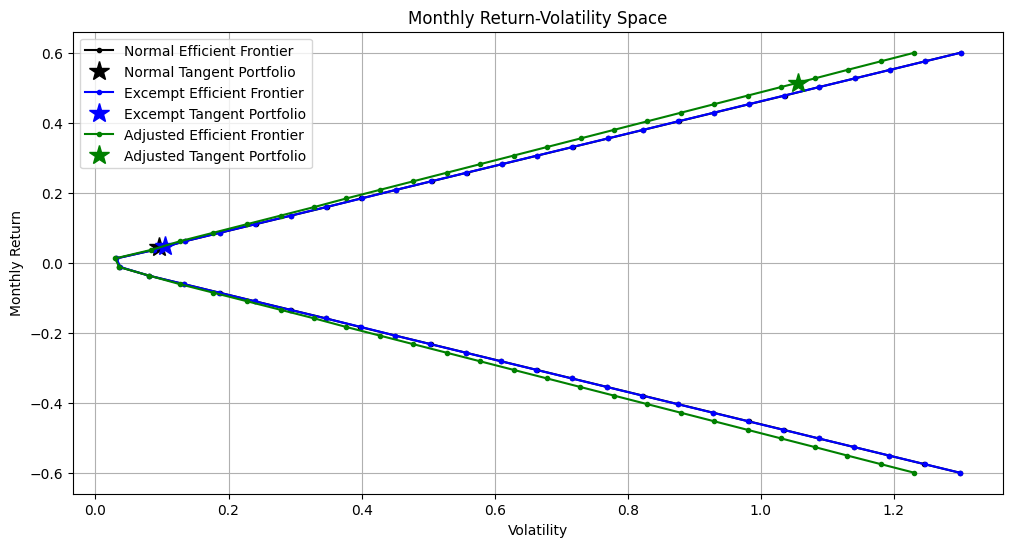

In [120]:
plt.figure(figsize=(12, 6))

# Normal
tangent_vol, tangent_return, tangent_weights = plot_return_vol_space(df_returns,
                      only_frontier=True,
                      sub_label="Normal ",
                      color="black",
                      )

# Exempt TIPS
df_returns_temp = df_returns.drop(columns=['TIP'])
tangent_vol, tangent_return, tangent_weights = plot_return_vol_space(df_returns_temp,
                      only_frontier=True,
                      sub_label="Excempt ",
                      color="blue",
                      )

# Adjust TIPS
df_returns_temp = df_returns.copy()
df_returns_temp['TIP'] += 0.0012
tangent_vol, tangent_return, tangent_weights = plot_return_vol_space(df_returns_temp,
                      only_frontier=True,
                      sub_label="Adjusted ",
                      color="green",
                      )
plt.show()

- **Dropping from portfolio: **The difference is about .001, convert to annual is 1 bp. 
- **Adjusting mean of TIPS:** This has a significant impact in the weightings, return and volatility.

I dont think its worth going through all this trouble of talking to the commitee and rebalancing just to get 1bp. Also we see that the portfolio is highly sensative the mean of tips. So we should wait until we have more data and can have a better estimate for the mean.

***

# 3. Allocations

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code.

* Continue with the same data file as the previous section.

* Suppose the investor has a targeted mean excess return (per month) of $\mutarg$ = 0.01.

Build the following portfolios:

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,
$$\wEW_i = \frac{1}{n}$$



#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$



#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 



In [121]:
def create_portfolios(df_returns, mu_target):
    mu_hat=df_returns.mean().values
    sigma_hat=df_returns.cov().values
    
    port_weights = {
        'Tangent': tangent_portfolio(mu_hat, sigma_hat)[2],
        'Equally-weighting': np.ones_like(mu_hat),
        'Risk Parity': 1/np.diagonal(sigma_hat),
        'Regularized': tangent_portfolio(mu_hat, 
                                         (sigma_hat + np.diag(np.diagonal(sigma_hat)) ) / 2
                                         )[2],
    }
    
    # Scale to target
    for name, weights in port_weights.items():
        port_weights[name] *= mu_target / np.dot(weights, mu_hat)
    
    # Returns
    df_port_returns = pd.DataFrame({name : df_returns @ weights 
                                         for name, weights in port_weights.items()})
    
    # Statistics
    df_port_stats = calc_summary(df_port_returns)
    for name, weights in port_weights.items():
        df_port_stats.loc["sum weights", name] = sum(weights)
    return port_weights, df_port_returns, df_port_stats

port_weights, df_port_returns, df_port_stats = create_portfolios(df_returns, .01)

# Check target
for name, weights in port_weights.items():
    print(f"{name}: {weights.dot(df_returns.mean()):.2f}")

Tangent: 0.01
Equally-weighting: 0.01
Risk Parity: 0.01
Regularized: 0.01



### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?

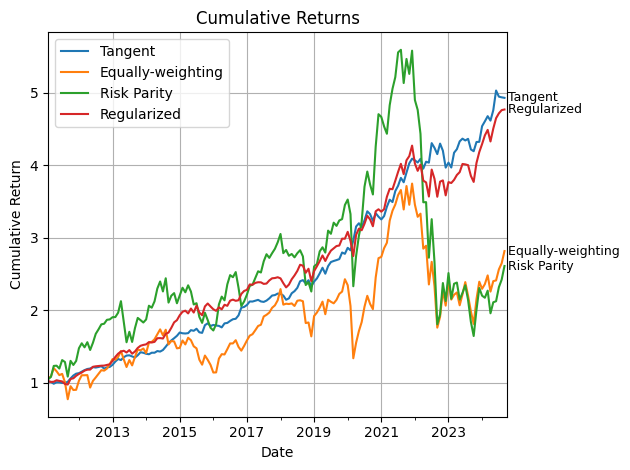

,Tangent,Equally-weighting,Risk Parity,Regularized
mean,0.010000,0.010000,0.010000,0.010000
std,0.021583,0.084157,0.089349,0.029619
sharpe,0.463334,0.118826,0.111920,0.337617
sum weights,-0.227585,2.987328,5.507806,0.789321


In [122]:
# Plot cumulative returns
plot_cumulative_returns(df_port_returns)

# Calculate and print statistics for each portfolio
display(df_port_stats)


How do these compare across the four allocation methods?

The regularized portfolio has better volatility and thus a better sharpe ratio. The risk parity has a lot of volatility, possible due to it having the most leverage. All performed badly during covid

***

# 4. Out-of-Sample Performance

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. One-step Out-of-Sample (OOS) Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
* Using only data through the end of `2022`, compute the weights built in Section 3.
* Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\mutarg$.
* Using those weights, calculate the portfolio’s Sharpe ratio within that sample.
* Again using those weights, (derived using data through `2022`,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in `2023-2024`.

## 2. Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,
* Start at the end of `2015`, and calculate the weights through that time. Rescale them using the mean returns through that time.
* Apply the weights to the returns in the upcoming year, (`2016`.)
* Step forward a year in time, and recompute.
* Continue until again calculating the weights through `2023` and applying them to the returns in `2024`.

Report the mean, volatility, and Sharpe from this dynamic approach for the following portfolios:
* mean-variance (tangency)
* equally-weighted
* risk-parity
* regularized

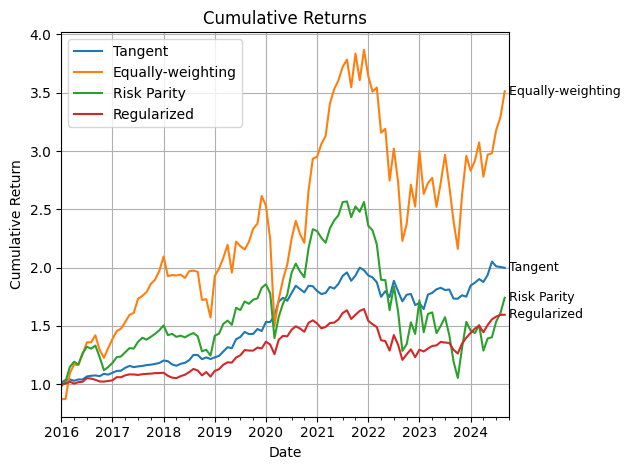

,Tangent,Equally-weighting,Risk Parity,Regularized
mean,0.006955,0.016038,0.008419,0.004956
std,0.026275,0.088870,0.078837,0.031469
sharpe,0.264704,0.180461,0.106787,0.157479


In [123]:
df_rolling_returns = []
for year in np.arange(2015, 2024):
    target_return = .01

    df_prev_returns = df_returns[df_returns.index.year <= year]
    port_weights, df_port_returns, df_port_stats = create_portfolios(df_prev_returns, target_return)

    df_future_returns = df_returns[df_returns.index.year == year+1]
    df_future_returns = pd.DataFrame({name : df_future_returns @ weights 
                                            for name, weights in port_weights.items()})
    
    df_rolling_returns.append(df_future_returns)
df_rolling_returns = pd.concat(df_rolling_returns)
df_rolling_port_stats = calc_summary(df_rolling_returns)
    
# Plot cumulative returns
plot_cumulative_returns(df_rolling_returns)
display(df_rolling_port_stats)

***

# 5. Without a Riskless Asset

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

Re-do Section 2 above, but in the model without a risk-free rate.

That is, build the MV allocation using the two-part formula in the `Mean-Variance` section of the notes.
* This essentially substitutes the risk-free rate with the minimum-variance portfolio.
* Now, the allocation depends nonlinearly on the target mean return, $\mutarg$. (With a risk-free rate, we simply scale the weights up and down to achieve the mean return.)

You will find that, conceptually, the answers are very similar. 

***

In [124]:
dfs_raw["total returns"]["SHV"]

0      0.000090
1      0.000173
2      0.000544
3     -0.000099
4      0.000173
         ...   
159    0.004582
160    0.004198
161    0.004599
162    0.004979
163    0.004586
Name: SHV, Length: 164, dtype: float64

In [125]:
df_total_returns = dfs_raw["total returns"].drop(columns='SHV')
df_total_returns = df_total_returns.set_index("Date")

# Determine risk free rate
mean_risk_free_rate = dfs_raw["total returns"]["SHV"].mean()

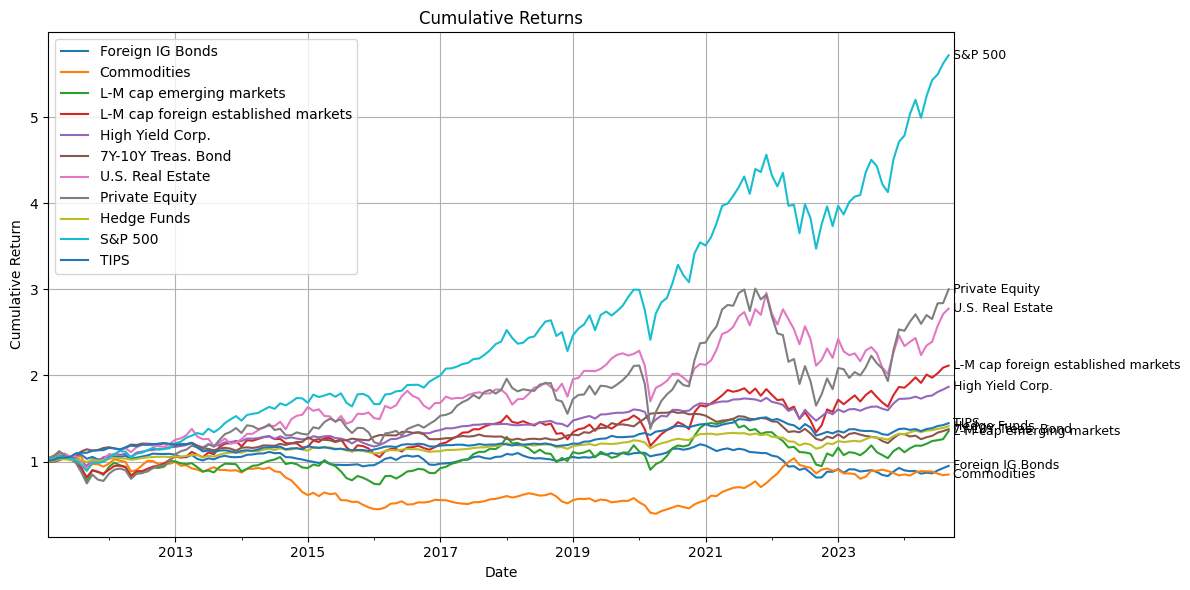

In [126]:
plt.figure(figsize=(12, 6))
plot_cumulative_returns(df_total_returns.rename(columns=custom_ticker_mapping))

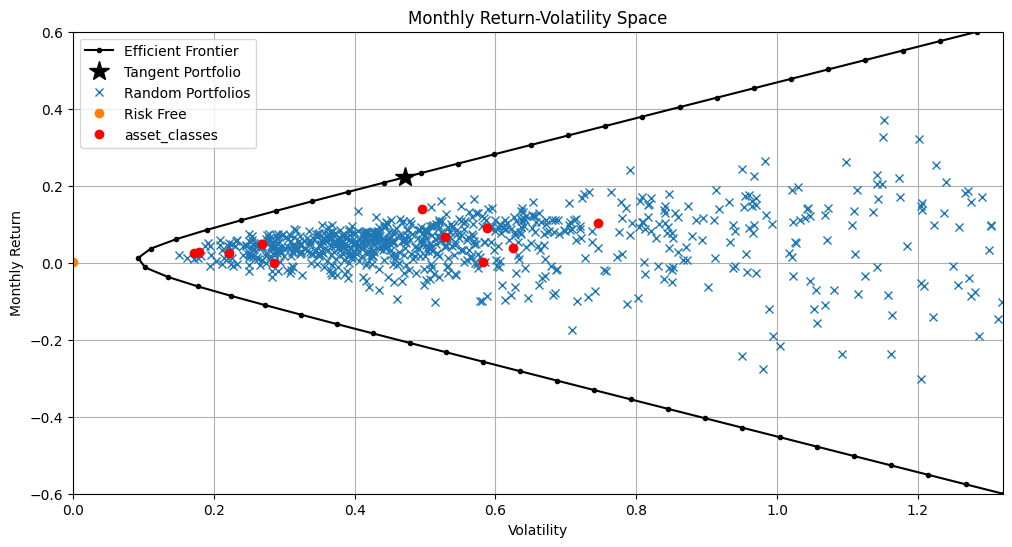

Tangency Portfolio Weights: ['-1.29', '0.04', '0.16', '-0.18', '0.50', '1.86', '-0.41', '-0.29', '-1.34', '1.84', '0.11']
Tangency Portfolio Sum of Weights: 1.00
Tangency Portfolio Mean Return: 0.22
Tangency Portfolio Volatility: 0.47
Tangency Portfolio Sharpe Ratio: 0.47


In [127]:
plt.figure(figsize=(12, 6))
tangent_vol, tangent_return, tangent_weights = plot_return_vol_space(df_total_returns * 12, risk_free_rate=mean_risk_free_rate)
plt.show()

print(f"Tangency Portfolio Weights: {[f'{weight:.2f}' for weight in tangent_weights]}")
print(f"Tangency Portfolio Sum of Weights: {sum(tangent_weights):.2f}")
print(f"Tangency Portfolio Mean Return: {tangent_return:.2f}")
print(f"Tangency Portfolio Volatility: {tangent_vol:.2f}")
print(f"Tangency Portfolio Sharpe Ratio: {tangent_return / tangent_vol:.2f}")